# Natural Language Processing  - Jupyter Notebook
### Cecilia, Conor, Francesco 
december 2019


# Intallation of differents packages

In [1]:
# pip install nltk 
# from the pop up window install: punkt, Averaged perceptron Tagger
# nltk.download()

In [2]:
#pip install spacy

# Importation of packages

In [97]:
import copy
import json
import nltk
from nltk.tag import StanfordNERTagger
import os
import spacy
import textacy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from gensim.models import word2vec
from sklearn.cluster import KMeans
from sklearn import cluster, metrics
from sklearn import neighbors, datasets
import snowballstemmer
from nltk.corpus import stopwords
import itertools
from string import ascii_lowercase
import seaborn as sns

In [ ]:
# # import these modules 
# from nltk.stem import WordNetLemmatizer 
  
# lemmatizer = WordNetLemmatizer() 
  
# print("rocks :", lemmatizer.lemmatize("rocks")) 
# print("corpora :", lemmatizer.lemmatize("corpora")) 
  
# # a denotes adjective in "pos" 
# print("better :", lemmatizer.lemmatize("better", pos ="a")) 

# Importing and Cleaning the data

In [4]:
stemmer = snowballstemmer.EnglishStemmer()
stop = stopwords.words('english')
stoplist = stemmer.stemWords(stop)
stoplist = set(stoplist)
stop = set(sorted(stop + list(stoplist)))

In [5]:
tickers= pd.read_json('/Users/macbookpro/Documents/GitHub/nlp/data/word_vectors/SP500_Tickers.json', typ='series')


url2='/Users/macbookpro/Documents/GitHub/nlp/data/word_vectors/article_headers_with_dates.txt'
url3 = '/Users/macbookpro/Documents/GitHub/nlp/parsed_scrapes/main.csv'
url4 = '/Users/macbookpro/Downloads/parsed_main.csv'
header = pd.read_csv(url4,sep=",")
#del header['Unnamed: 0']
header= header.drop_duplicates()
header[(header['Date']=='31/10/19') & (header['Headline'].str.contains('goods rivals'))].loc[41725,'Headline']
header

,Date,Headline,Provider
0,20/03/17,"​ UDAY states see Rs 11,989-crore drop in inte...",Economic Times India
1,24/01/17,Income Tax India: 1 taxpayer owes 11 percent o...,Economic Times India
2,17/10/16,10 billion unhedged gap in foreign exchange de...,Economic Times India
3,19/01/17,10 percent cost reduction can add 5.5 billion ...,Economic Times India
5,11/08/15,​10 percent ethanol blending can save 1.7 bill...,Economic Times India
...,...,...,...
41770,20/10/08,Why bond prices could collapse,Money Week
41771,24/08/07,Why is the carry trade so dangerous?,Money Week
41772,16/03/09,Why the dollar will get even stronger from here,Money Week
41773,3/04/08,New biofuel laws are utter madness,Money Week


In [6]:
# remove characters and stoplist words, then generate dictionary of unique words
data = header

data['Original_Headline'] = data['Headline']

data['Headline'].replace('[!"#%\'()*+,-./:;<=>?@\[\]^_`{|}~1234567890’”“′‘\\\$&]','',inplace=True,regex=True)

extensions_list = ['reuters','Reuters','bloomberg', 'may','also','could','would', 'na','&amp','gets', 'getting', 'get','must','might','may','across','among','beside','however','yet','within']+list(ascii_lowercase)

stop = stop.union(set(extensions_list))

wordlist = filter(None, " ".join(list(set(list(itertools.chain(*data['Headline'].str.split(' ')))))).split(" "))

data['Headline'] = [' '.join(filter(None,filter(lambda word: word not in stop, line))) for line in data['Headline'].str.lower().str.split(' ')]

header = data

In [7]:
ticker = tickers.to_frame('Ticker').reset_index()
ticker.columns=['Name','Ticker']
ticker

,Name,Ticker
0,AGILENT TECHNOLOGIES,A
1,AMERICAN AIRLINES,AAL
2,ADVANCE AUTO PARTS,AAP
3,APPLE,AAPL
4,ABBVIE,ABBV
...,...,...
495,XYLEM,XYL
496,YUM! BRANDS,YUM
497,ZIMMER BIOMET HOLDINGS,ZBH
498,ZIONS BANCORPORATION NA,ZION


In [8]:
list_ticker = ticker['Name'].to_list()

list_tick = ticker['Ticker'].to_list()
str3 = '|'.join(list_tick)
str1 = '|'.join(list_ticker)
str1 = str1 + str3
str1 = str1.lower()
str1

"agilent technologies|american airlines|advance auto parts|apple|abbvie|amerisourcebergen|abiomed|abbott laboratories|accenture|adobe|analog devices|archer-daniels-midland|automatic data processing|alliance data systems|autodesk|ameren|american electric power|aes|aflac|allergan|american international|apartment investment & management|assurant|arthur j gallagher &|akamai technologies|albemarle|align technology|alaska air|allstate|allegion|alexion pharmaceuticals|applied materials|amcor|advanced micro devices|ametek|affiliated managers|amgen|ameriprise financial|american tower|amazoncom|arista networks|ansys|anthem|aon|a o smith|apache|air products & chemicals|amphenol|aptiv|alexandria real estate equities|arconic|atmos energy|activision blizzard|avalonbay communities|broadcom|avery dennison|american water works|american express|autozone|boeing|bank of america|baxter international|bb&t|best buy|becton dickinson &|franklin resources|brown-forman|baker hughes a ge|biogen|bank of new york m

In [9]:
isin = pd.DataFrame(header['Headline'].str.contains(str1, regex=True))
isin

/Users/macbookpro/anaconda3/lib/python3.7/site-packages/pandas/core/strings.py:1843: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


,Headline
0,True
1,True
2,True
3,True
5,True
...,...
41770,True
41771,True
41772,True
41773,True


In [10]:
index = isin[isin['Headline']==True].reset_index()['index']
#ticker.loc[index,'Ticker']
#ticker
index

0            0
1            1
2            2
3            3
4            5
         ...  
40656    41770
40657    41771
40658    41772
40659    41773
40660    41774
Name: index, Length: 40661, dtype: int64

In [11]:
index = isin[isin['Headline']==True].reset_index()['index']
index
header = header.loc[index,:].reset_index()#[['Date','Header']]

In [12]:
header

,index,Date,Headline,Provider,Original_Headline
0,0,20/03/17,​ uday states see rs crore drop interest cost,Economic Times India,"​ UDAY states see Rs 11,989-crore drop in inte..."
1,1,24/01/17,income tax india taxpayer owes percent indias ...,Economic Times India,Income Tax India: 1 taxpayer owes 11 percent o...
2,2,17/10/16,billion unhedged gap foreign exchange deposit ...,Economic Times India,10 billion unhedged gap in foreign exchange de...
3,3,19/01/17,percent cost reduction add billion indias trad...,Economic Times India,10 percent cost reduction can add 5.5 billion ...
4,5,11/08/15,​ percent ethanol blending save billion forex ...,Economic Times India,​10 percent ethanol blending can save 1.7 bill...
...,...,...,...,...,...
40656,41770,20/10/08,bond prices collapse,Money Week,Why bond prices could collapse
40657,41771,24/08/07,carry trade dangerous,Money Week,Why is the carry trade so dangerous?
40658,41772,16/03/09,dollar even stronger,Money Week,Why the dollar will get even stronger from here
40659,41773,3/04/08,new biofuel laws utter madness,Money Week,New biofuel laws are utter madness


# SVO and Name Entity Recognition

In [13]:
#extraction = list(textacy.extract.subject_verb_object_triples(example))


nlp = spacy.load('en_core_web_sm')

#header = 'Goldman Sachs announce purchase of Microsoft'

# Enter your username in here. I've put the paths you wrote as an attribute in the dictionary below
user = 'Francesco'

# Dictionary containing the Java paths for each user
java_paths = {
    'Conor': '/usr/lib/jvm/java-8-openjdk-amd64',
    'Francesco': '/Users/macbookpro/Downloads/jdk-13.0.1.jdk/Contents/Home/bin/java',
    'Cecilia': 'C:/Program Files/Java/jdk-13.0.1/bin/java.exe'
}
os.environ['JAVAHOME'] = java_paths[user]

st = StanfordNERTagger(
    '/Users/macbookpro/Documents/GitHub/nlp/ner/stanford-ner-2014-06-16/classifiers/english.all.3class.distsim.crf.ser.gz',
    '/Users/macbookpro/Documents/GitHub/nlp/ner/stanford-ner-2014-06-16/stanford-ner.jar',
    encoding = 'utf-8'
)
COMPANY_TYPES = ['PERSON', 'ORGANIZATION']

def get_ticker1(name, tickers):
    for key, val in tickers.items():
        # Check if this is a ticker
        if val.upper() == name.upper():
            return f'__{val}'
        
        # Check that this is 
        if name.upper() in key.upper():
            return f'__{val}'
    return None

# def parse_header(header, max_company_name_length = max((len(x) for x in tickers))):
def parse_header1(header,tickers,orig):
    '''Attempt to replace all organisations in a header with their ticker'''
    header = header.lower()
    nlp_header = nlp(header)
    
#     print('nlp header', nlp_header)
#     print(type(nlp_header))

    tokens = list(textacy.extract.subject_verb_object_triples(nlp_header))  
    
#     print('tokens', tokens)
    
    
    parsed_words = []
    for i in range(len(tokens)):
        ticker_0 = get_ticker1(str(tokens[i][0]), tickers)
        ticker_2 = get_ticker1(str(tokens[i][2]), tickers)  
        sub = str(tokens[i][0])
        obj = str(tokens[i][2])
        tick_sub = ''
        tick_obj = ''
        if ticker_0 is not None:
            sub = ticker_0
            tick_sub = 'sub'
        if ticker_2 is not None:
            obj = ticker_2
            tick_obj = 'obj'
        verb = str(tokens[i][1])
        tick = tick_sub + tick_obj
        
        if (ticker_0 != None) | (ticker_2 != None):
            parsed_words.append([sub, verb, obj, tick, header,orig])
        
    return parsed_words

In [14]:
print(len(header['Headline']))

svo_df = pd.DataFrame(columns = ['Date', 'Sub', 'Verb', 'Obj', 'Tick_Type', 'Headlines', 'Original Headline'])

for i in range (len(header['Headline'])):
    #print(i)
    headline = header.loc[i,'Headline']
    orig_head = header.loc[i,'Original_Headline'] 
    date = header.loc[i,'Date']
    svo_headlines = parse_header1(headline,tickers,orig_head)
    
    for ls in svo_headlines:
        svo_df.loc[len(svo_df)] =  [date] + ls

    
svo_df

40661


,Date,Sub,Verb,Obj,Tick_Type,Headlines,Original Headline
0,10/08/16,__EL,default,pf payments,sub,companies default pf payments epfo,"10,932 companies default on PF payments to EPFO"
1,22/08/17,__AMG,crore,revenue loss year,sub,gst states see rs crore revenue loss year gst,"GST: 11 states may see Rs 9,500 crore revenue ..."
2,25/02/15,recommendations,gives,__PKI,obj,th finance commission government accepts recom...,14th Finance Commission: Government accepts re...
3,25/02/15,recommendations,gives,__MKTX,obj,th finance commission government accepts recom...,14th Finance Commission: Government accepts re...
4,8/02/16,psu banks,write,__AMG,obj,psu banks write rs lakh crore bad debts,27 PSU banks write off Rs 1.14 lakh crore bad...
...,...,...,...,...,...,...,...
4577,28/10/19,__CF,set,interestrate cut,sub,money minute monday october us set interestrat...,Money Minute Monday 28 October: US set for an ...
4578,29/10/19,__DRE,falling,terms,sub,house prices uk still gently falling real terms,House prices in the UK are still gently fallin...
4579,1/11/19,__BXP,close,village,sub,properties close village green,Properties close to a village green
4580,31/10/19,goods rivals,fight,__TIF,obj,luxury goods rivals fight tiffany amp co,Will luxury goods rivals fight for Tiffany &am...


In [15]:
test = svo_df
svo_df['Date'] = pd.to_datetime(svo_df['Date'])

svo_df = svo_df.sort_values(by='Date')

length_training = int(np.floor(len(svo_df)*80/100))
date = svo_df['Date'].values
critical_date = date[length_training]
print(critical_date)
# print([x for x in svo_df['Verb'] if len(x.split(' ')) > 1])
# length_training = int(np.floor(len(svo_df)*80/100))
training = svo_df[svo_df['Date']<=critical_date]
test_data = svo_df[svo_df['Date']>critical_date]
training
# print((training.index))
# svo_df
#training.loc[40,'Obj']

#print(type(test.loc[1,'Date']))

2019-02-01T00:00:00.000000000


,Date,Sub,Verb,Obj,Tick_Type,Headlines,Original Headline
3134,1970-01-01,venezuela,came,__CBOE,obj,venezuela came one biggest markets crypto worl...,How Venezuela Came to Be One of the Biggest Ma...
3126,1970-01-01,__ACN,works,thailands,sub,accenture works thailands oldest bank release ...,Accenture Works With Thailand’s Oldest Bank to...
3816,1970-01-01,__A,cracked,fool,sub,fundsmiths terry smith good hes cracked motley...,Is Fundsmith’s Terry Smith as good as he’s cra...
222,2003-02-28,deduction income tax,raised,__AMG,obj,standard deduction income tax raised rs,Standard deduction for income tax raised to Rs...
4332,2006-03-07,time,sell,__GS,obj,time sell goldman,Why it's time to sell Goldman
...,...,...,...,...,...,...,...
2784,2019-02-01,__UAL,releases,cookbook airline food,sub,united airlines releases new cookbook airline ...,United Airlines releases new cookbook of airli...
2785,2019-02-01,__GS,accelerates,renewal modernization plan,sub,gol accelerates fleet renewal modernization plan,"GOL accelerates fleet renewal, modernization plan"
2786,2019-02-01,renew contract,managed,__CHTR,obj,speedcast carnival renew contract fully manage...,"Speedcast, Carnival renew contract for fully m..."
2787,2019-02-01,__TRV,see,need,sub,go group survey finds travelers see need impro...,GO Group survey finds travelers see need for i...


# Word2Vec

In [16]:
model=word2vec.Word2Vec.load('/Users/macbookpro/Documents/GitHub/nlp/word_vectors/models/model_1')
X = model[model.wv.vocab]

/Users/macbookpro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [17]:
num_clusters = 100
kmeans = cluster.KMeans(n_clusters=num_clusters)
kmeans.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=100, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

## Create phrases vectors
#### (Concatenating the vectors)

In [18]:
data = []

to_parse = {
    'obj': 'Sub',
    'sub': 'Obj',
    'subobj': 'Verb'
}

for i in training.index:
    entry = {}
    for key in ['Date', 'Sub', 'Verb','Obj', 'Tick_Type', 'Headlines', 'Original Headline']:
        entry[key] = training.loc[i, key]
        
#     print(entry['Verb'])
    
    try:
        verb_vector = model.wv[entry['Verb'].upper()]
    except:
        verb_vector = None
    key_to_parse = to_parse[entry['Tick_Type']]
    
    try:
        other_vector = model.wv[entry[key_to_parse].upper()]
    except:
        other_vector = None
        
    if verb_vector is not None and other_vector is not None:
        final_vector = np.concatenate((verb_vector, other_vector))
        entry['final_vector'] = final_vector
    else:
        entry['final_vector'] = None
    
    data.append(entry)
    


In [19]:
print(data)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



# Determine which tickers are the most quoted by articles

3667


IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



,tickers,counts
0,__CBOE,148
12,__CF,75
36,__ALXN,68
43,__HBAN,57
41,__AAL,46


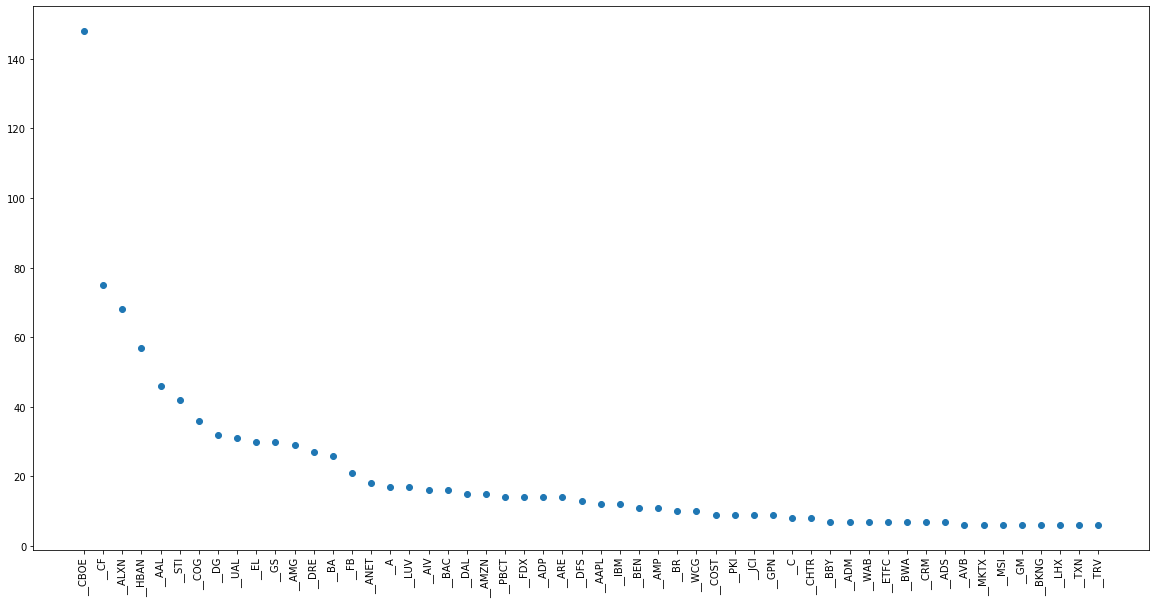

In [20]:
print(len(data))
print(data)
tickers_list = []
for x in data:
    if (x['Tick_Type'] == 'sub')&(x['final_vector'] is not None):
        tickers_list.append(x['Sub'])
    elif (x['Tick_Type'] == 'obj')&(x['final_vector'] is not None):
        tickers_list.append(x['Obj'])

#print(tickers_list)

from collections import Counter
counts = dict(Counter(tickers_list))

to_parse = {'tickers': [], 'counts': []}
for ticker, count in counts.items():
    to_parse['tickers'].append(ticker)
    to_parse['counts'].append(count)
print(to_parse)
    

ticker_counts = pd.DataFrame(to_parse)
ticker_counts = ticker_counts.sort_values(by = 'counts', ascending = False)
ticker_counts1 = ticker_counts[ticker_counts['counts']>5]
plt.figure(figsize = [20,10])
plt.scatter(ticker_counts1['tickers'], ticker_counts1['counts'])
plt.xticks(rotation = 'vertical')
#print(json.dumps(counts, indent = 2))
ticker_counts.head()
# plt.figure(figsize=(10,5))
# chart = sns.countplot(
#     data = ticker_counts,
#     x='tickers',
#     y = 'counts',
#     palette='Set1'
# )
# chart.set_xticklabels(chart.get_xticklabels(), rotation=45)

# Clustering phrases vectors

In [21]:
relevant_data = [x for x in data if x['final_vector'] is not None]

In [22]:
# vocab = [x['final_vector'] for x in data if x['final_vector'] is not None]

vocab = [x['final_vector'] for x in relevant_data]
num_clusters = 100
kmeans = cluster.KMeans(n_clusters = num_clusters)
kmeans.fit(vocab)
print(len(vocab))

1660


# Mapping

In [23]:
centroids = kmeans.cluster_centers_
labels = kmeans.labels_
print(len(labels))
# print(centroids)

1660


In [24]:
for i in range(len(relevant_data)):
    relevant_data[i]['cluster_label'] = labels[i]

In [25]:
n_neighbors = 5
y = labels

h = .02  # step size in the mesh

for weights in ['uniform', 'distance']:
    # we create an instance of Neighbours Classifier and fit the data.
    clf = neighbors.KNeighborsClassifier(n_neighbors, weights=weights, algorithm = 'ball_tree')
    clf.fit(vocab, y)

In [26]:
print(clf.fit(vocab, y))

KNeighborsClassifier(algorithm='ball_tree', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=None, n_neighbors=5, p=2,
           weights='distance')


In [27]:
A = clf.kneighbors([vocab[2]],n_neighbors)
A
# print(type([vocab[2]]))

(array([[ 0.        , 16.44023058, 26.22357258, 26.31952923, 26.37463315]]),
 array([[   2, 1599,  637,  759, 1386]]))

# Returns study

In [49]:
returnsdf = pd.read_csv('/Users/macbookpro/Documents/GitHub/nlp/data/returns/returnsSP500.csv')
returnsdf

# print(len(returnsdf.columns))
# print('GOOG' in returnsdf.columns)

,Date,A,AAL,AAP,AAPL,ABBV,ABC,ABMD,ABT,ACN,...,XEL,XLNX,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
0,2000-01-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2000-01-04,-0.076389,NaN,NaN,-0.084310,NaN,-0.068273,-0.023973,-0.028571,NaN,...,0.023026,-0.022727,-0.019154,0.000000,-0.046512,NaN,-0.020100,NaN,-0.048423,NaN
2,2000-01-05,-0.062030,NaN,NaN,0.014634,NaN,0.077586,0.010526,-0.001838,NaN,...,0.038585,-0.021888,0.054516,0.017287,0.051490,NaN,0.005128,NaN,-0.001183,NaN
3,2000-01-06,-0.038076,NaN,NaN,-0.086538,NaN,0.076000,0.001736,0.034991,NaN,...,-0.009288,-0.086713,0.051698,0.001307,-0.020619,NaN,-0.008503,NaN,0.014218,NaN
4,2000-01-07,0.083333,NaN,NaN,0.047368,NaN,0.130112,-0.005199,0.010676,NaN,...,0.000000,0.113323,-0.002935,-0.002611,0.023684,NaN,-0.022298,NaN,0.002336,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5008,2019-11-27,0.001606,-0.003442,0.010758,0.013432,0.006954,0.007513,0.013024,0.000000,0.001642,...,0.006211,0.023126,-0.000582,0.001227,0.013055,0.005962,0.008922,0.011735,0.008256,-0.002133
5009,2019-11-29,-0.003823,-0.007254,-0.010707,-0.002203,-0.006793,-0.006779,-0.003100,0.000351,-0.000447,...,-0.001137,-0.006106,-0.008297,-0.009981,0.003351,-0.001288,0.000298,-0.008734,-0.005792,-0.009126
5010,2019-12-02,-0.005200,-0.022965,-0.003374,-0.011562,-0.007979,-0.000910,-0.020186,-0.011001,-0.007805,...,-0.004716,-0.027053,0.004257,0.002830,-0.011045,-0.012385,-0.001093,-0.005644,-0.005625,-0.005061
5011,2019-12-03,-0.003111,-0.028134,-0.025168,-0.017830,-0.012410,-0.004554,-0.005567,-0.001775,-0.004209,...,0.004248,-0.017946,-0.007892,0.007584,-0.006494,-0.013194,-0.011038,-0.007338,-0.018788,0.005171


In [29]:
print(len(returnsdf.columns))
#print(returnsdf.columns[22:100])

501


In [30]:
params = pd.read_csv('/Users/macbookpro/Documents/GitHub/nlp/data/SP500_parameters.csv')
params['Ticker_b']=params['Ticker']
params['Ticker']='__'+params['Ticker']
params
# params.loc[50:100,'Ticker_b']


,Ticker,Beta,Name,GICS,Ticker_b
0,__A,1.165846,Agilent Technologies Inc,Health Care,A
1,__AAL,1.570904,American Airlines Group,Industrials,AAL
2,__AAP,0.680250,Advance Auto Parts,Consumer Discretionary,AAP
3,__AAPL,1.488606,Apple Inc.,Information Technology,AAPL
4,__ABBV,0.889469,AbbVie Inc.,Health Care,ABBV
...,...,...,...,...,...
496,__XYL,1.096964,Xylem Inc.,Industrials,XYL
497,__YUM,0.484074,Yum! Brands Inc,Consumer Discretionary,YUM
498,__ZBH,0.901953,Zimmer Biomet Holdings,Health Care,ZBH
499,__ZION,1.049443,Zions Bancorp,Financials,ZION


In [31]:
params[params['Ticker_b']=='FLS']

'FLS' in returnsdf.columns

True

In [32]:

ticker_counts.columns=['Ticker','count']
ticker_counts = ticker_counts.merge(params[['Ticker','GICS']],on = 'Ticker')


## Which industries are the most tackled by headlines 
##### in order to have enough data to study

Text(0, 0.5, 'Number of Articles')

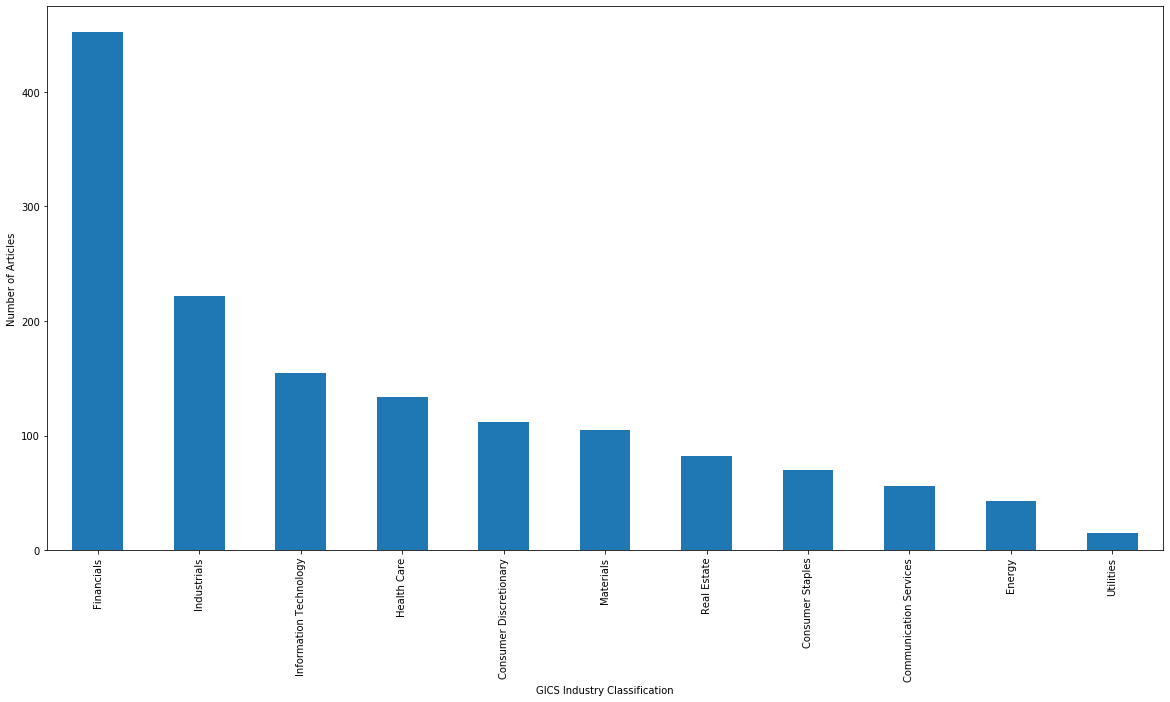

In [33]:
GICS_count = ticker_counts.groupby(['GICS']).agg(['sum'])
GICS_count =GICS_count.sort_values(by = ('count','sum'),ascending=False)
# GICS_count
# plt.plot(GICS_count[('count','sum')])

plt.figure(figsize = [20,10])
# plt.plot(GICS_count[('count','sum')], marker = 'o')
GICS_count[('count','sum')].plot(kind='bar')
# plt.bar(GICS_count['count'], GICS_count['sum'])

plt.xlabel('GICS Industry Classification')
plt.ylabel('Number of Articles')

# plt.xticks(rotation = 'horizontal')

# GICS_count = GICS_count.sort_values(by = 'count', ascending = False)

In [34]:
industries = set(params['GICS'].values)

dataframe_industry_dict = {}
for industry in industries:
    industry_tickers = params.loc[params['GICS'] == industry, 'Ticker']
    industry_tickers = industry_tickers.str.replace('__','')
    industry_tickers = industry_tickers.str.replace('.','-')
    
    industry_tickers = list(set(industry_tickers) & set(returnsdf.columns))
    df_industry = returnsdf[industry_tickers + ['Date']]
    
    df_industry['market_exp'] = df_industry[industry_tickers].mean(axis=1)
    df_industry = df_industry.iloc[1:,:]#.dropna()
    cols = df_industry.columns
    cols = cols[-2:].append(cols[:(len(cols)-2)])
    df_industry = df_industry[cols]
    dataframe_industry_dict[industry] = df_industry
#print(len(healthy_ticker))

#print(len(df_health.columns))
# df_health
dataframe_industry_dict['Financials']


/Users/macbookpro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':


,Date,market_exp,GS,MCO,CME,AIG,CMA,IVZ,PFG,TRV,...,JPM,FITB,SPGI,FRC,LNC,WFC,AON,AMG,AFL,AIZ
1,2000-01-04,-0.035024,-0.062987,-0.028902,NaN,-0.051112,-0.041667,-0.016816,NaN,-0.013258,...,-0.027444,-0.042039,-0.045989,NaN,-0.028800,-0.049521,-0.022436,-0.079932,-0.026536,NaN
2,2000-01-05,-0.006698,-0.046828,-0.017857,NaN,0.002376,-0.002899,-0.042189,NaN,-0.007678,...,-0.006173,-0.014939,-0.013453,NaN,-0.034596,-0.010084,0.029508,-0.024030,-0.005739,NaN
3,2000-01-06,0.023833,0.042789,0.000000,NaN,0.030504,0.029070,-0.011905,NaN,0.019342,...,0.014197,0.035071,-0.027273,NaN,0.010239,0.044143,0.035032,0.030303,0.020202,NaN
4,2000-01-07,0.021625,0.003799,0.024242,NaN,0.074847,-0.001412,0.037349,NaN,0.039848,...,0.018373,-0.006410,0.009346,NaN,0.025338,0.017886,0.052308,0.023897,0.019802,NaN
5,2000-01-10,-0.013937,0.021953,0.000000,NaN,-0.017694,-0.032532,-0.005807,NaN,-0.018248,...,-0.017182,-0.026267,0.069444,NaN,0.001647,-0.031949,-0.295322,0.025135,-0.059639,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5008,2019-11-27,0.004481,0.002248,-0.000882,-0.023753,-0.005266,0.008960,0.008547,0.010432,0.001171,...,0.002962,0.001985,-0.005245,0.013217,0.011395,0.009849,0.005117,0.003503,0.001644,-0.001872
5009,2019-11-29,-0.002879,-0.007176,0.000618,0.008707,-0.004349,-0.007471,-0.007910,-0.001992,-0.000877,...,-0.002272,-0.003301,-0.003202,-0.004439,-0.007062,0.002208,-0.003231,-0.006748,0.000365,-0.003226
5010,2019-12-02,-0.008494,-0.016761,-0.006485,0.002910,-0.018990,-0.004403,-0.015376,-0.022686,-0.010679,...,-0.002201,-0.002650,-0.009295,0.001547,-0.007959,-0.015424,-0.009872,-0.021905,-0.039387,-0.008730
5011,2019-12-03,-0.014515,-0.024812,-0.001776,0.003935,-0.009485,-0.016405,-0.034702,-0.027855,-0.004732,...,-0.012855,-0.020591,0.006903,-0.009085,-0.041482,-0.019396,-0.007986,-0.020599,-0.018033,-0.024372


# LIBOR 3M importation

In [35]:
libor = pd.read_excel('/Users/macbookpro/Documents/GitHub/nlp/data/LIBOR_3M.xlsx')
libor['LIBOR 3M'] = libor['LIBOR 3M']/100
libor['Date'] = pd.to_datetime(libor['Date'])
libor

,Date,LIBOR 3M
0,2010-01-01,0.002506
1,2010-01-04,0.002544
2,2010-01-05,0.002525
3,2010-01-06,0.002500
4,2010-01-07,0.002494
...,...,...
2481,2019-07-08,0.023377
2482,2019-07-09,0.023407
2483,2019-07-10,0.023395
2484,2019-07-11,0.023034


In [36]:
for industry in industries:
    test = dataframe_industry_dict[industry]
    test['Date'] = pd.to_datetime(test['Date'])
    test = test.merge(libor,on = 'Date')
    
    cols = test.columns
    cols = cols[-1:].append(cols[:(len(cols)-1)])
    test = test[cols]
    
    dataframe_industry_dict[industry] = test
    
dataframe_industry_dict['Financials']

,LIBOR 3M,Date,market_exp,GS,MCO,CME,AIG,CMA,IVZ,PFG,...,JPM,FITB,SPGI,FRC,LNC,WFC,AON,AMG,AFL,AIZ
0,0.002544,2010-01-04,0.018151,0.025113,0.017537,0.019199,-0.003002,0.031451,-0.006386,0.039933,...,0.028318,0.037949,0.002984,NaN,0.040193,0.012227,-0.010433,0.022717,0.028541,0.023066
1,0.002525,2010-01-05,0.010028,0.017680,-0.010268,-0.000818,-0.018735,0.003607,0.005570,0.023600,...,0.019370,0.026680,0.000893,NaN,0.020866,0.027452,-0.006326,0.007985,0.029010,0.029841
2,0.002500,2010-01-06,0.003747,-0.010673,-0.021119,-0.006781,-0.006478,0.022215,-0.020878,-0.006643,...,0.005494,0.005775,-0.008918,NaN,0.015140,0.001425,-0.000265,0.019588,0.008784,-0.002898
3,0.002494,2010-01-07,0.019587,0.019568,-0.003028,0.001236,-0.019218,0.054330,0.003046,0.008655,...,0.019809,0.060287,0.022196,NaN,0.023490,0.036286,-0.002918,-0.004520,0.010733,0.012270
4,0.002512,2010-01-08,0.001277,-0.018911,0.018983,0.026717,0.026592,-0.012731,-0.005640,0.001170,...,-0.002456,0.000903,-0.003815,NaN,-0.015301,-0.009269,0.008249,-0.009224,-0.010018,0.000638
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2392,0.023377,2019-07-08,-0.008997,-0.010341,-0.019113,-0.004043,0.006409,-0.015073,-0.018121,-0.009522,...,-0.005463,-0.010229,-0.019451,-0.005990,-0.005889,-0.005024,-0.005618,-0.016804,-0.002816,0.003269
2393,0.023407,2019-07-09,0.004561,0.009818,0.002379,0.000000,0.010189,0.010712,0.001943,0.003777,...,0.004253,0.007128,-0.003916,0.014464,-0.006380,0.006312,0.000407,0.010054,-0.002118,0.001810
2394,0.023395,2019-07-10,-0.005527,-0.008663,0.008685,0.005842,0.003782,-0.016105,-0.009695,-0.006670,...,-0.002911,-0.021939,0.014170,-0.004950,-0.006268,-0.014217,0.006461,0.001548,-0.000354,-0.006053
2395,0.023034,2019-07-11,0.006526,0.026120,0.009461,0.015947,-0.004486,0.014969,-0.030837,0.002410,...,0.009556,0.014834,0.015676,0.006368,0.017077,-0.000212,-0.005965,0.005079,-0.002654,0.000818


# Computation of abnormal returns

In [93]:
abret_dict = {}
for industry in industries:
    df_returns = dataframe_industry_dict[industry]
    capm = pd.DataFrame(df_returns['Date'])
    risk_free_rate = df_returns['LIBOR 3M']
    market_avg_returns = df_returns['market_exp']
    
    abret_dict[industry] = pd.DataFrame(df_returns['Date'])
    
    for col in df_returns.columns[3:]:
        col = col.replace('-', '.')
        
        beta = params.loc[params['Ticker_b'] == col]['Beta'].values[0]
        stock_returns = returnsdf[col.replace('.', '-')]
        
        capm[col] = risk_free_rate + beta*(market-risk_free_rate)
        
        abret_dict[industry][col] = stock_returns - capm[col]
        abret_dict[industry] = abret_dict[industry].where((pd.notnull(abret_dict[industry])), None)
        
abret_dict['Financials']

,Date,GS,MCO,CME,AIG,CMA,IVZ,PFG,TRV,BEN,...,JPM,FITB,SPGI,FRC,LNC,WFC,AON,AMG,AFL,AIZ
0,2010-01-04,None,None,None,None,None,None,None,None,None,...,None,None,None,None,None,None,None,None,None,None
1,2010-01-05,-0.0686572,-0.0346807,None,-0.0562496,-0.0470539,-0.0228571,None,-0.017639,-0.023374,...,-0.0326948,-0.0473808,-0.0512112,None,-0.0352559,-0.05444,-0.0272166,-0.0860716,-0.0310356,None
2,2010-01-06,-0.044833,-0.0157076,None,0.0036088,-0.0013087,-0.0396654,None,-0.00752493,0.0179903,...,-0.00477839,-0.013415,-0.0120994,None,-0.0314795,-0.00916295,0.0302313,-0.0213648,-0.00541783,None
3,2010-01-07,0.0325264,-0.0105302,None,0.0215592,0.0195069,-0.023082,None,0.0122637,0.0511209,...,0.00497187,0.0256215,-0.0364271,None,-0.00196329,0.0357357,0.0269671,0.0188822,0.0128322,None
4,2010-01-08,0.0117547,0.032558,None,0.0810263,0.00559979,0.0465368,None,0.0435133,0.0152438,...,0.0249299,0.000449394,0.0158077,None,0.0359063,0.0233409,0.0573015,0.0334127,0.0238593,None
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2392,2019-07-08,0.0327837,0.00520594,-0.0022158,-0.281007,0.00441945,0.0278826,0.00972633,-0.010595,-0.00391168,...,0.0239611,0.0241475,0.00163473,None,0.0233902,0.00991855,-0.00668035,0.00382102,-0.0040305,0.0279301
2393,2019-07-09,-0.0115355,-0.0142059,-0.0313826,0.232617,-0.0229318,-0.0219984,-0.0264417,-0.0121596,-0.000838827,...,-0.0430865,-0.0369449,-0.00254057,None,-0.0438764,-0.0248614,-0.0122574,-0.0119454,-0.0204464,-0.0306166
2394,2019-07-10,0.0497979,0.0431119,0.0189876,0.234131,0.0561982,0.0805745,0.0986711,0.0242076,0.0410063,...,0.0670738,0.0891644,0.00690729,None,0.0596095,0.0760911,0.0134558,0.0442028,0.0592105,0.0385609
2395,2019-07-11,0.0199638,0.0359091,-0.0217772,-0.00571064,0.0277375,0.0169317,0.0120439,-0.0198146,0.0295681,...,0.0126574,0.000178889,0.0253627,None,0.0469808,-0.00755699,0.00834295,0.0466693,0.026512,-0.00248414


In [100]:
# Define a lookup function to return, for a given ticker, 
# start_date and horizon, the cumulative average returns over that period

def lookup_cumul_returns(ticker, start_date, horizon):
    '''
    Args:
    start_date (pd.Timestamp)
    '''
    
    try:
        industry_classification = params.loc[params['Ticker_b'] == ticker, 'GICS'].values[0]
    except:
        print(ticker)
        return None
        
    relevant_df = abret_dict[industry_classification]
    
    start_index_values = relevant_df.loc[pd.to_datetime(relevant_df['Date']) >= pd.Timestamp(start_date),:].index.values
    
    if len(start_index_values) == 0:
        return None
    else:
        start_index = start_index_values[0]

    end_index = start_index + horizon
    
    if end_index > len(relevant_df):
        return None
    
    relevant_returns = relevant_df.loc[start_index + 1:end_index, ticker]
    
    to_return = relevant_returns.cumsum().values[-1] / horizon
    
    if np.isnan(to_return):
        return None
    
    else:
        return to_return
    
output = lookup_cumul_returns('A', '2010-01-04', 3)
print(output)

-0.0635173372510704


In [101]:
horizons = [3, 5, 10]

print(list(relevant_data[0].keys()))

# Add a column with the referenced ticker for each headline
for i, el in enumerate(relevant_data):
    lookup_col = el['Tick_Type']
    if lookup_col in ['sub', 'obj']:
        el['Ticker'] = el[lookup_col.capitalize()]
    else:
        el['Ticker'] = None
        
    relevant_data[i] = el
    
relevant_data = [x for x in relevant_data if x['Ticker'] is not None]
    
# {
#     3 {
#         'headlines': [(Sub, Verb, Obj), (), ...],
#         '3 day': [],
#         '5 day': []
#     }
# }

# Set up the data structure. Each entry looks like the above
cluster_labels = set([x['cluster_label'] for x in relevant_data])

cluster_sentiments = {}
for label in cluster_labels:
    cluster_sentiments[label] = {
        'svos': [],
        'headlines': [],
    }
    for horizon in horizons:
        cluster_sentiments[label]['{}_days'.format(horizon)] = []       
        
for el in relevant_data:
    svo = (el['Sub'], el['Verb'], el['Obj'])
    start_date = el['Date']
    ticker = el['Ticker'].replace('__', '')
    
    cluster_label = el['cluster_label']
    headline = el['Original Headline']
    
    cluster_sentiments[cluster_label]['svos'].append(svo)
    cluster_sentiments[cluster_label]['headlines'].append(headline)
    
    for horizon in horizons:
        horizon_cumul_returns = lookup_cumul_returns(ticker, start_date, horizon)
        cluster_sentiments[cluster_label]['{}_days'.format(horizon)].append(horizon_cumul_returns)        
        

['Date', 'Sub', 'Verb', 'Obj', 'Tick_Type', 'Headlines', 'Original Headline', 'final_vector', 'cluster_label', 'Ticker']
BHGE
BHGE
BHGE
CELG
CELG
CELG
CELG
CELG
CELG
HCP
HCP
HCP
HCP
HCP
HCP


In [163]:
parsed_sentiments = copy.deepcopy(cluster_sentiments)


for label in cluster_sentiments:
    for horizon in horizons:
        entries = cluster_sentiments[label]['{}_days'.format(horizon)]
        non_null_entries = [x for x in entries if x is not None]
        parsed_sentiments[label]['{}_days'.format(horizon)] = np.mean(non_null_entries)

# Remove any clusters which have all nan values
for label, contents in parsed_sentiments.items():
    all_nan = True
    for horizon in horizons:
        if not np.isnan(contents['{}_days'.format(horizon)]):
            all_nan = False
            break
    
    if all_nan:
        print(label)
        del parsed_sentiments[label]
        
cluster_labels = list(parsed_sentiments.keys())

In [161]:
for label, contents in parsed_sentiments.items():
    print('cluster {}'.format(label))
    for horizon in [3,5,10]:
#         print(contents)
        print(contents['{}_days'.format(horizon)])

cluster 0
0.018194550710322863
0.007209746925372345
0.011644914580838045
cluster 1
-0.011656039729977547
0.019431710607651614
0.0026135063477340185
cluster 2
-0.0023705560389059486
-0.007352401771308705
-0.003923491052943291
cluster 3
0.004107420994056317
0.0015599902045942895
0.00020884465335060408
cluster 5
-0.007750404717727227
0.003262678458325683
0.00015852801973837276
cluster 6
-0.006039058445199018
0.003655770518544857
0.003269181484132885
cluster 7
-0.012214066087526388
-0.009204615533908429
-0.005358053725311754
cluster 8
-0.002281166842573951
-0.00020815239381784918
-0.0021056296059453754
cluster 9
0.005835423402542204
0.003633178682649376
0.0012985690808677954
cluster 10
0.00046825636421016746
0.0018621078916982192
0.0031696622452663924
cluster 12
0.006135047472995501
0.004748189968320535
0.00494722147001131
cluster 13
-0.016728935025987858
-0.013622062175449765
-0.00875988477943039
cluster 14
-0.001329435282920421
-0.0007275813443846422
0.0012687722737148245
cluster 15
-0.0

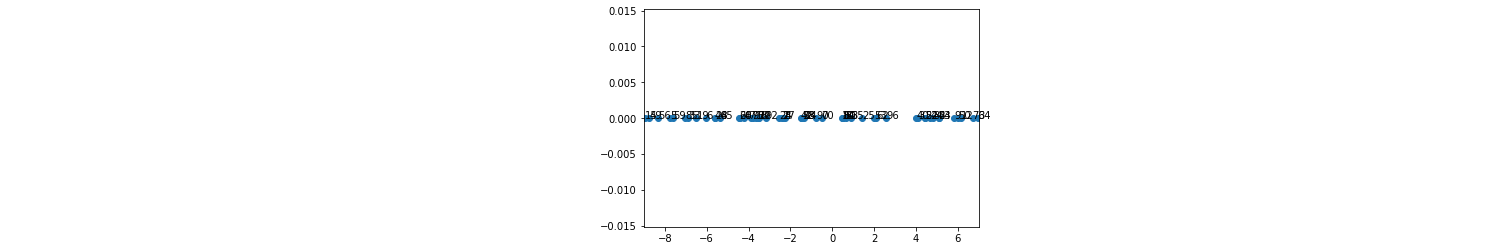

In [164]:
small_days_sentiment=[]
medium_days_sentiment = []
large_days_sentiment = []
for x in cluster_labels:
    small_days_sentiment.append(1000*parsed_sentiments[x]['3_days'])
    medium_days_sentiment.append(parsed_sentiments[x]['5_days'])
    large_days_sentiment.append(parsed_sentiments[x]['10_days'])

# fig,ax = plt.subplots(figsize = (20,4))
fig, ax = plt.subplots()
# fig(figsize = (20,20))
plt.scatter(small_days_sentiment,np.zeros(len(cluster_labels)))
label_graph=[str(list(cluster_labels)[i]) for i in range(len(cluster_labels))]
plt.xlim(-9,7)
for i,txt in enumerate(label_graph):
    ax.annotate(txt,(small_days_sentiment[i],np.zeros(len(cluster_labels))[i]))


## FORECASTING

In [165]:
def clean(headlines, stopwords):
    '''
    Args:
    headlines: pd.Series
    '''
    headlines = headlines.str.lower()
    
    headlines.replace('[!"#%\'()*+,-./:;<=>?@\[\]^_`{|}~1234567890’”“′‘\\\$&]','', inplace = True, regex=True)
    extensions_list = ['co','reuters','Reuters','bloomberg', 'may','also','could','would', 'na','&amp','gets', 'getting', 'get','must','might','may','across','among','beside','however','yet','within']+list(ascii_lowercase)

    stopwords = stopwords.union(set(extensions_list))

    wordlist = filter(None, " ".join(list(set(list(itertools.chain(*headlines.str.split(' ')))))).split(" "))

    headlines = [' '.join(filter(None,filter(lambda word: word not in stopwords, line))) for line in headlines.str.lower().str.split(' ')]
    
    return headlines

In [185]:
def closest_cluster_sentiment(headline, tickers):
    '''
    Returns the closest cluster to the new headline
    
    Args:
    headline (str)
    clusters (dict)
    '''
    
    n_neighors = 5
    
    # Get SVO of the new headline
    cleaned_headline = clean(pd.Series([headline]), stop)
    ticker_info = parse_header1(cleaned_headline[0], tickers, None)
    
    headline_sentiment = {}
    
    headline_sentiment = {
        '3_days': [],
        '5_days': [],
        '10_days': []
    }
    
    if len(ticker_info) != 0:
        try :
            for ls in ticker_info:
                ticker_key = ls[3]

                if ticker_key == 'obj':
                    ticker = ls[2]
                    svo = [ls[0],ls[1]]
                    svo_vec = [np.concatenate((model.wv[ls[1].upper()], model.wv[ls[0].upper()]))]

    #                 close_neighbors = clf.kneighbors(svo_vec,n_neighbors)
    #                 cluster_list = [labels[neigh[1][0][i]] for i in range(n_neighbors)]

                if ticker_key == 'sub':
                    ticker = ls[0]
                    svo = [ls[1],ls[2]]
                    svo_vec = [np.concatenate((model.wv[ls[1].upper()], model.wv[ls[2].upper()]))]


                close_neighbors = clf.kneighbors(svo_vec,n_neighbors)
                clusters_list = [labels[close_neighbors[1][0][i]] for i in range(n_neighors)]
                distances_list = [close_neighbors[0][0][i] for i in range(n_neighors)]

                closest_cluster_label = clusters_list[0]
                for horizon in horizons:
                    closest_cluster_horizon_sentiment = parsed_sentiments[closest_cluster_label]['{}_days'.format(horizon)]
                    headline_sentiment['{}_days'.format(horizon)] = closest_cluster_horizon_sentiment
                
        except:
            return None


            
#             for horizon in horizons:
#                 for cluster in clusters_list:
#                     headline_sentiment['{}_days'.format(horizon)].append(parsed_sentiments[cluster]['{}_days'.format(horizon)])
                
#                 headline_sentiment['{}_days'.format(horizon)] = np.mean(headline_sentiment['{}_days'.format(horizon)]) 
             

                
    return headline_sentiment



In [167]:
def inverse_distance_sentiment(headline, parsed_sentiments, tickers, labels, horizons):
    '''
    Returns the closest cluster to the new headline
    
    Args:
    headline (str)
    clusters (dict)
    tickers (dict): list of company name: ticker pairs
    horizons (iterable): iterable of horizon lengths to consider
    '''
    p = 2
    n_neighbours = len(labels)
    
    # Get SVO of the new headline
    cleaned_headline = clean(pd.Series([headline]), stop)
    ticker_info = parse_header1(cleaned_headline[0], tickers, None)
    
    headline_sentiment = {'{}_days'.format(horizon): [] for horizon in horizons}
    
    if len(ticker_info) == 0:
        return None
    try :
        for ls in ticker_info:
            ticker_key = ls[3]

            if ticker_key == 'obj':
                ticker = ls[2]
                svo = [ls[0],ls[1]]
                svo_vec = [np.concatenate((model.wv[ls[1].upper()], model.wv[ls[0].upper()]))]

            elif ticker_key == 'sub':
                ticker = ls[0]
                svo = [ls[1],ls[2]]
                svo_vec = [np.concatenate((model.wv[ls[1].upper()], model.wv[ls[2].upper()]))]

            else:
                # Skip if this is a subobj ticker label
                continue

            neighbours = clf.kneighbors(svo_vec, n_neighbours)
            clusters_list = list(set([labels[neighbours[1][0][i]] for i in range(n_neighbours)]) & set(list(parsed_sentiments.keys())))
            distances_list = [neighbours[0][0][i] for i in range(n_neighbours)]

            new_clusters_list = []
            new_distances_list = []

            for index, label in enumerate(clusters_list):
                if label in parsed_sentiments:
                    new_clusters_list.append(clusters_list[index])
                    new_distances_list.append(distances_list[index])


            distances_list = new_distances_list
            clusters_list = new_clusters_list
            
            #### NOTE! This is not correct

            for horizon in horizons:
                if 0 in distances_list :
                    headline_sentiment['{}_days'.format(horizon)] = parsed_sentiments[clusters_list[0]]['{}_days'.format(horizon)]
                else:
                    weights = np.array(list(map(lambda x: x**(-p), np.array(distances_list))))
                    sentiments = [parsed_sentiments[i]['{}_days'.format(horizon)] for i in clusters_list]
                    
                    if len(sentiments) == 0:
                        print(headline)
                    
                    if len(weights) == 0:
                        print(headline)
                        
                    print('sentiments', sentiments)
                    print('')
                    print('weights', weights)
                        
                    headline_sentiment['{}_days'.format(horizon)] = np.average(sentiments, weights = weights)
                    
                    print(headline_sentiment['{}_days'.format(horizon)])
                    
                    if np.isnan(headline_sentiment['{}_days'.format(horizon)]):
                        print('was nan before')
                        headline_sentiment['{}_days'.format(horizon)] = None

#                 print('headline')
#                 print(headline_sentiment['{}_days'.format(horizon)])
#                 print(sentiments)
#                 print(weigths)
                    
#                     print(headline_sentiment['{}_days'.format(horizon)])
#                     print(sentiments)
#                     print(weights)
                    
                    
#                         if headline_sentiment['{}_days'.format(horizon)] == [] or len(headline_sentiment['{}_days'.format(horizon)]) == 0:
#                     if headline_sentiment['{}_days'.format(horizon)] == [] or len(headline_sentiment['{}_days'.format(horizon)]) == 0:
#                         print('headline:')
#                         print(headline)
    except:
        print('exception')
        return None
    
    all_empty = True
    for val in headline_sentiment.values():
        if type(val) == np.float64:
            all_empty = False
            break
            
    if all_empty:
        print('all empty')
        return None

    return headline_sentiment


In [183]:
nlp = spacy.load('en_core_web_sm')
fake_news = 'Conor cuts investment'

# def parse_header(header, max_company_name_length = max((len(x) for x in tickers))):
# def parse_header1(header,tickers,orig):
# parsed_words.append([sub, verb, obj, tick, header, orig])

# print(closest_cluster(fake_news, parsed_sentiments, tickers))
# svo_vec = [np.concatenate((model.wv['CUTS'], model.wv['BANK']))]
# tested_news = "Food for thought: investing in the future of food"

# dictionary = closest_cluster_sentiment(fake_news, parsed_sentiments, tickers)
# output = inverse_distance_sentiment(fake_news, parsed_sentiments, tickers, labels, horizons)

output = closest_cluster_sentiment(fake_news, tickers)

print(output)

# print(parsed_sentiments[40])

# print(list(parsed_sentiments.keys))

# print(type(model.wv['CUTS']))
# neigh = clf.kneighbors(svo_vec,n_neighbors)
# print(neigh[1]0])
# print([labels[neigh[1][0][i]] for i in range(5)])
# print(labels)

[['conor', 'cuts', '__AIV', 'obj', 'conor cuts investment', None]]
[40, 40, 40, 40, 40]
[15.888278272711924, 16.431919226872143, 16.445430666054428, 16.644132065574958, 18.01880626591433]
{'3_days': 0.0040145523348318135, '5_days': 0.0033655630409184533, '10_days': 1.8041324348852934e-05}


In [186]:
testing_output = []

for index in test_data.index:
    date = test_data.loc[index, 'Date']
    headline = test_data.loc[index, 'Headlines']
    
    if test_data.loc[index, 'Tick_Type'] == 'obj':
        ticker = test_data.loc[index, 'Obj']
    if test_data.loc[index, 'Tick_Type'] == 'sub':
        ticker = test_data.loc[index, 'Sub']
#     else:
#         ticker = None
    info = {
        'date': date,
        'headline': headline,
        'ticker' : ticker
    }
    
#     horizon_sentiments = inverse_distance_sentiment(
#         headline = headline,
#         parsed_sentiments = parsed_sentiments,
#         tickers = tickers,
#         labels = labels,
#         horizons = horizons
#     )

    horizon_sentiments = closest_cluster_sentiment(
        headline = headline,
        tickers = tickers
    )
    
    if horizon_sentiments is not None:
        for horizon in horizons:
            info['{}_days'.format(horizon)] = horizon_sentiments['{}_days'.format(horizon)]
            
        testing_output.append(info)

In [187]:
testing_df = pd.DataFrame(testing_output)
testing_df

# print(len(testing_df))

,date,headline,ticker,3_days,5_days,10_days
0,2019-02-03,spacex launch crew dragon lifts us seeks run m...,__CF,-0.002281,-0.000208,-0.002106
1,2019-02-04,instinctif partners advert one agree strategic...,__AZO,0.005835,0.003633,0.001299
2,2019-02-04,eu warns liquidity risks financial disruption ...,__ALXN,0.005835,0.003633,0.001299
3,2019-02-04,diageo gives uk staff fully paid week equal pa...,__DRE,-0.008965,-0.008933,0.003981
4,2019-02-04,herald tried tested investment trust,__FRT,0.002098,0.001334,0.000438
...,...,...,...,...,...,...
320,2019-12-06,facebook create jobs new london engineering ce...,__FB,0.005835,0.003633,0.001299
321,2019-12-06,nodeal brexit see uk flooded cheap copies brit...,__DRE,0.001988,0.002877,0.003652
322,2019-12-07,swiss stocks keep lid european shares pharma d...,__HBAN,-0.007592,-0.000883,0.003892
323,2019-12-07,ancient art sparks controversy,__AAP,0.002098,0.001334,0.000438


In [188]:
testing_df[testing_df['headline']=='delta take percent stake latam airlines']

,date,headline,ticker,3_days,5_days,10_days


In [189]:
for horizon in horizons:
    for i in testing_df.index:
        date = testing_df.loc[i,'date']
        ticker = testing_df.loc[i,'ticker']
        ticker = ticker.replace('__','')
        cumul = lookup_cumul_returns(ticker, date, horizon)
        #print(cumul)
        testing_df.loc[i,str(horizon)+'_days_actual'] = cumul
        
testing_df = testing_df.dropna()
testing_df

,date,headline,ticker,3_days,5_days,10_days,3_days_actual,5_days_actual,10_days_actual
0,2019-02-03,spacex launch crew dragon lifts us seeks run m...,__CF,-0.002281,-0.000208,-0.002106,0.009418,0.011963,0.008339
1,2019-02-04,instinctif partners advert one agree strategic...,__AZO,0.005835,0.003633,0.001299,-0.016197,-0.015573,-0.010508
2,2019-02-04,eu warns liquidity risks financial disruption ...,__ALXN,0.005835,0.003633,0.001299,-0.011615,0.013524,0.004874
3,2019-02-04,diageo gives uk staff fully paid week equal pa...,__DRE,-0.008965,-0.008933,0.003981,-0.001269,-0.012869,-0.028214
4,2019-02-04,herald tried tested investment trust,__FRT,0.002098,0.001334,0.000438,-0.010727,-0.012385,-0.018823
...,...,...,...,...,...,...,...,...,...
149,2019-06-27,neil woodfords debacle teach us liquidity,__CF,0.002098,0.001334,0.000438,-0.007411,-0.012501,-0.003993
150,2019-06-27,indians money swiss banks falls hits secondlow...,__STI,0.006701,0.002762,0.003164,-0.024484,-0.023681,-0.000958
151,2019-06-27,singapore airlines malaysia airlines explore w...,__AAL,0.002098,0.001334,0.000438,-0.004497,-0.019834,-0.004841
152,2019-06-28,old car youre alone vehicle age hits record,__CAH,0.002098,0.001334,0.000438,-0.014239,-0.012482,-0.004570


In [190]:
for horizon in horizons:
    testing_df[str(horizon)+'_dir_comparison'] = testing_df[str(horizon)+'_days_actual']*testing_df[str(horizon)+'_days']
  

testing_df 

/Users/macbookpro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,date,headline,ticker,3_days,5_days,10_days,3_days_actual,5_days_actual,10_days_actual,3_dir_comparaison,5_dir_comparaison,10_dir_comparaison
0,2019-02-03,spacex launch crew dragon lifts us seeks run m...,__CF,-0.002281,-0.000208,-0.002106,0.009418,0.011963,0.008339,-0.000021,-0.000002,-1.755954e-05
1,2019-02-04,instinctif partners advert one agree strategic...,__AZO,0.005835,0.003633,0.001299,-0.016197,-0.015573,-0.010508,-0.000095,-0.000057,-1.364516e-05
2,2019-02-04,eu warns liquidity risks financial disruption ...,__ALXN,0.005835,0.003633,0.001299,-0.011615,0.013524,0.004874,-0.000068,0.000049,6.328816e-06
3,2019-02-04,diageo gives uk staff fully paid week equal pa...,__DRE,-0.008965,-0.008933,0.003981,-0.001269,-0.012869,-0.028214,0.000011,0.000115,-1.123111e-04
4,2019-02-04,herald tried tested investment trust,__FRT,0.002098,0.001334,0.000438,-0.010727,-0.012385,-0.018823,-0.000023,-0.000017,-8.235709e-06
...,...,...,...,...,...,...,...,...,...,...,...,...
149,2019-06-27,neil woodfords debacle teach us liquidity,__CF,0.002098,0.001334,0.000438,-0.007411,-0.012501,-0.003993,-0.000016,-0.000017,-1.747061e-06
150,2019-06-27,indians money swiss banks falls hits secondlow...,__STI,0.006701,0.002762,0.003164,-0.024484,-0.023681,-0.000958,-0.000164,-0.000065,-3.031601e-06
151,2019-06-27,singapore airlines malaysia airlines explore w...,__AAL,0.002098,0.001334,0.000438,-0.004497,-0.019834,-0.004841,-0.000009,-0.000026,-2.118110e-06
152,2019-06-28,old car youre alone vehicle age hits record,__CAH,0.002098,0.001334,0.000438,-0.014239,-0.012482,-0.004570,-0.000030,-0.000017,-1.999520e-06


In [191]:
direction_test = testing_df
direction_result_dict ={}
for horizon in horizons :
    pos = len(direction_test.loc[direction_test[str(horizon)+'_dir_comparison']>0,:])
    tot = len(direction_test)
    direction_result_dict[horizon]=pos/tot
    
direction_result_dict
    

{3: 0.46564885496183206, 5: 0.5267175572519084, 10: 0.44274809160305345}

In [192]:
magnitude_test = testing_df

for horizon in horizons :
    magnitude_test[str(horizon)+'_rel_gap']= abs(magnitude_test[str(horizon)+'_days_actual']-magnitude_test[str(horizon)+'_days'])/magnitude_test[str(horizon)+'_days_actual']
    
magnitude_test

/Users/macbookpro/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


,date,headline,ticker,3_days,5_days,10_days,3_days_actual,5_days_actual,10_days_actual,3_dir_comparaison,5_dir_comparaison,10_dir_comparaison,3_rel_gap,5_rel_gap,10_rel_gap
0,2019-02-03,spacex launch crew dragon lifts us seeks run m...,__CF,-0.002281,-0.000208,-0.002106,0.009418,0.011963,0.008339,-0.000021,-0.000002,-1.755954e-05,1.242211,1.017400,1.252494
1,2019-02-04,instinctif partners advert one agree strategic...,__AZO,0.005835,0.003633,0.001299,-0.016197,-0.015573,-0.010508,-0.000095,-0.000057,-1.364516e-05,-1.360284,-1.233304,-1.123581
2,2019-02-04,eu warns liquidity risks financial disruption ...,__ALXN,0.005835,0.003633,0.001299,-0.011615,0.013524,0.004874,-0.000068,0.000049,6.328816e-06,-1.502405,0.731350,0.733555
3,2019-02-04,diageo gives uk staff fully paid week equal pa...,__DRE,-0.008965,-0.008933,0.003981,-0.001269,-0.012869,-0.028214,0.000011,0.000115,-1.123111e-04,-6.064266,-0.305841,-1.141089
4,2019-02-04,herald tried tested investment trust,__FRT,0.002098,0.001334,0.000438,-0.010727,-0.012385,-0.018823,-0.000023,-0.000017,-8.235709e-06,-1.195570,-1.107720,-1.023244
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149,2019-06-27,neil woodfords debacle teach us liquidity,__CF,0.002098,0.001334,0.000438,-0.007411,-0.012501,-0.003993,-0.000016,-0.000017,-1.747061e-06,-1.283063,-1.106722,-1.109575
150,2019-06-27,indians money swiss banks falls hits secondlow...,__STI,0.006701,0.002762,0.003164,-0.024484,-0.023681,-0.000958,-0.000164,-0.000065,-3.031601e-06,-1.273703,-1.116641,-4.301245
151,2019-06-27,singapore airlines malaysia airlines explore w...,__AAL,0.002098,0.001334,0.000438,-0.004497,-0.019834,-0.004841,-0.000009,-0.000026,-2.118110e-06,-1.466466,-1.067263,-1.090380
152,2019-06-28,old car youre alone vehicle age hits record,__CAH,0.002098,0.001334,0.000438,-0.014239,-0.012482,-0.004570,-0.000030,-0.000017,-1.999520e-06,-1.147323,-1.106885,-1.095740


In [ ]:
sentence = 'HSBC fires a new secretary'

print(list(textacy.extract.subject_verb_object_triples(nlp(sentence))))